# Új adatok előállítása, generatív modellek

Ezen notebook kiegészítséként szolgál a dolgozat 4. fejezetéhez.

## Tartalomjegyzék
1. [GAN modell tanítása](#GAN-modell-tanítása)
2. [Képeket előállító GAN modell](#Képeket-előállító-GAN-modell)
    - [Generátor](#Generátor)
    - [Diszkriminátor](#Diszkriminátor)
    - [Tanítás, mérések](#Tanítás,-mérések)
    - [Az architektúra gyengeségei, problémái](#Az-architektúra-gyengeségei,-problémái)
3. [GAN teljesítmény mérés](#GAN-teljesítmény-mérés)
4. [Mode collapse jelenség](#Mode-collapse-jelenség)
5. [Regularizációs módszerek](#Regularizációs-módszerek)
    - [Label-smoothing](#Label-smoothing)
    - [Megfelelő inicializációs stratégia](#Megfelelő-inicializációs-stratégia)
    - [Batch Normalization](#Batch-Normalization)
    - [Two Time-Scale Update Rule-(TTUR)](#Two-Time-Scale-Update-Rule-(TTUR))
6. [A képgeneráló modell kibővítési lehetőségei](#A-képgeneráló-modell-kibővítési-lehetőségei)
    - [Tanítás címkékkel](#Tanítás-címkékkel)
    - [Multi-Scale Gradient architektúra](#Multi-Scale-Gradient-architektúra)

In [1]:
import tensorflow as tf
from tensorflow import keras

import numpy as np

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.patches as patches
import matplotlib.ticker as ticker

import actplot.plotter as actplt

2022-05-05 12:38:42.062800: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-05-05 12:38:42.062835: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


## GAN modell tanítása

A tanításra a __training_examples__ jegyzékben találhatunk példákat. Ezen olyan notebook-ok, amelyekkel a GAN hálózat tanítása elvégezhető. Mivel igen nagy számításigénye van a tanításoknak, így ezen notebook nem tartalmaz futtatható tanítást.

A notebookok a különféle GAN modellek tanítására:

- ./training_examples/gan-dc-Afhq.ipynb
- ./training_examples/gan-dc-Cifar10.ipynb
- ./training_examples/gan-label_conditioning-Cifar10.ipynb
- ./training_examples/gan-msg-Afhq.ipynb
- ./training_examples/gan-msg-Cifar10.ipynb

## Képeket előállító GAN modell

Ezen architektúra természetesen a mai eredmények mellett egyszerűnek tűnhet elsőre, viszont a későbbi, fejlettebb architektúrákban többségében megfigyelhető, hogy ezen modellt vették alapul. Természetesen az architektúra egy igen egyszerű kiegészítést kínált az eredeti GAN hálózatra: konvolúciós rétegeket alkalmaz a rejtett rétegekben mind a Generátor, mind a Diszkriminátor esetében. A konvolúciós rétegek segítségével a képeken lévő összefüggő pixelek kapcsolatairól pontosabb reprezentációt kaphatunk, így képek generálásához is hasznos lehet a módszer.

<img src="images/DCGAN.png" width="100%">

In [2]:
# Látens tér dimenziószáma
latent_dim = 100

# Bemeneti zaj generálása
noise = tf.random.normal([1, latent_dim])

2022-05-05 12:38:43.920075: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-05-05 12:38:43.920143: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-05-05 12:38:43.920180: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (Inspiron-5558): /proc/driver/nvidia/version does not exist
2022-05-05 12:38:43.920633: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


### Generátor

A háló építését a Keras Sequential API-jával végeztem. Az elábi kódrészletben megfigyelhető, hogy a rétegek egy tömbben kerülnek megadásra.

In [3]:
generator = keras.Sequential([
    keras.layers.Reshape((1, 1, latent_dim), input_shape=[latent_dim]),
    keras.layers.Conv2DTranspose(512, (4, 4), (1, 1), 'valid',
                                 activation="relu",
                                 kernel_initializer="he_normal"),
    keras.layers.Conv2DTranspose(256, (4, 4), (2, 2), 'same',
                                 activation="relu",
                                 kernel_initializer="he_normal"),
    keras.layers.Conv2DTranspose(128, (4, 4), (2, 2), 'same',
                                 activation="relu",
                                 kernel_initializer="he_normal"),
    keras.layers.Conv2DTranspose(64, (4, 4), (2, 2), 'same',
                                 activation="relu",
                                 kernel_initializer="he_normal"),
    keras.layers.Conv2DTranspose(3, (4, 4), (2, 2), 'same',
                                 activation="relu"),
    keras.layers.Activation("tanh")
])

In [4]:
generator.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape (Reshape)            (None, 1, 1, 100)         0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 4, 4, 512)         819712    
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 8, 8, 256)         2097408   
_________________________________________________________________
conv2d_transpose_2 (Conv2DTr (None, 16, 16, 128)       524416    
_________________________________________________________________
conv2d_transpose_3 (Conv2DTr (None, 32, 32, 64)        131136    
_________________________________________________________________
conv2d_transpose_4 (Conv2DTr (None, 64, 64, 3)         3075      
_________________________________________________________________
activation (Activation)      (None, 64, 64, 3)         0

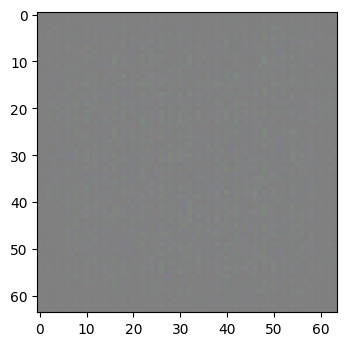

In [5]:
# A tanítás előtti generátor kimenete
generated_images = generator(noise, training=False)
gen_1 = (generated_images[0].numpy() * 127.5 + 127.5).astype("uint32")

fig = plt.figure(figsize=(3, 3), dpi=100)
ax = fig.add_axes([0, 0, 1, 1])
ax.imshow(gen_1)

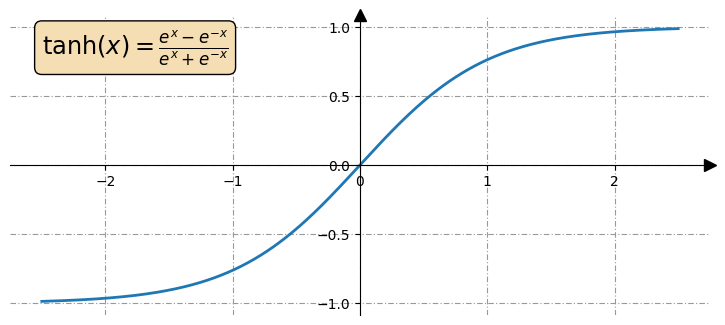

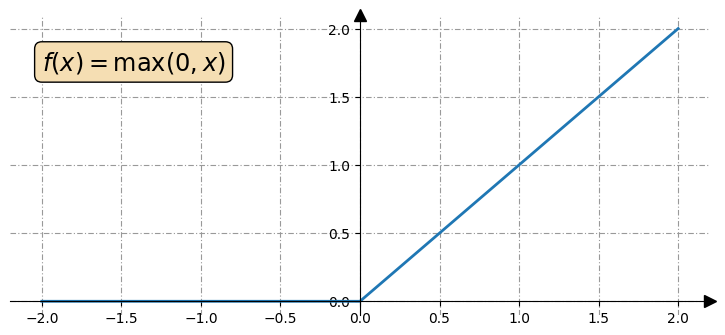

In [6]:
actplt.plot_tanh()

actplt.plot_relu()

### Diszkriminátor

In [7]:
discriminator = keras.Sequential([
    keras.layers.Conv2D(64, (4, 4), (2, 2), "same",
                        input_shape=(64, 64, 3), activation="relu",
                        kernel_initializer="he_normal"),
    keras.layers.Conv2D(128, (4, 4), (2, 2), "same",
                        activation="relu",
                        kernel_initializer="he_normal"),
    keras.layers.Conv2D(256, (4, 4), (2, 2), "same",
                        activation="relu",
                        kernel_initializer="he_normal"),
    keras.layers.Conv2D(512, (4, 4), (2, 2), "same",
                        activation="relu",
                        kernel_initializer="he_normal"),
    keras.layers.Conv2D(100, (4, 4), (1, 1), "valid",
                        activation="relu"),
    keras.layers.Flatten(),
    keras.layers.Dense(1)
])

In [8]:
discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 64)        3136      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 16, 128)       131200    
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 8, 8, 256)         524544    
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 4, 4, 512)         2097664   
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 1, 1, 100)         819300    
_________________________________________________________________
flatten (Flatten)            (None, 100)               0         
_________________________________________________________________
dense (Dense)                (None, 1)                

In [9]:
# Példa a használatra
# Logits kimenettel rendelkezik (nincs normalizálva)
discriminator(generated_images, training=False)

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[0.01177482]], dtype=float32)>

In [10]:
def plot_grid_of_images(images):
    plt.figure(figsize=(8, 8))

    for i in range(images.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow((images[i].numpy() * 127.5 + 127.5).astype("uint32"))
        plt.axis('off')
    plt.show()

In [11]:
dcgan_generator = keras.models.load_model('./datas/weights/dcgan/animaldc/generator.h5')

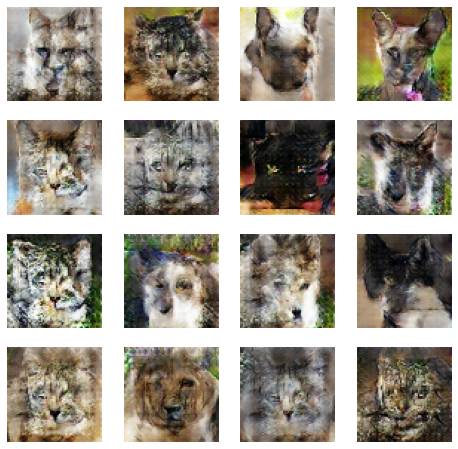

In [12]:
# Példa az AFHQ-n betanított modell kimeneteire
noise = tf.random.normal([16, latent_dim])
generated_images = dcgan_generator(noise, training=False)
plot_grid_of_images(generated_images)

### Tanítás, mérések

A felvázolt architektúrát az AFHQ dataset-en, Adam optimalizációs módszerrel, 0.0004 learning rate hiperparaméter mellett tanítva a hibaértékek a következő ábrához hasonlóan alakulnak:

In [13]:
gen_losses = np.load("datas/losses/dcgan/gen_losses.npy")
disc_losses = np.load("datas/losses/dcgan/disc_losses.npy")

batch_size = 16

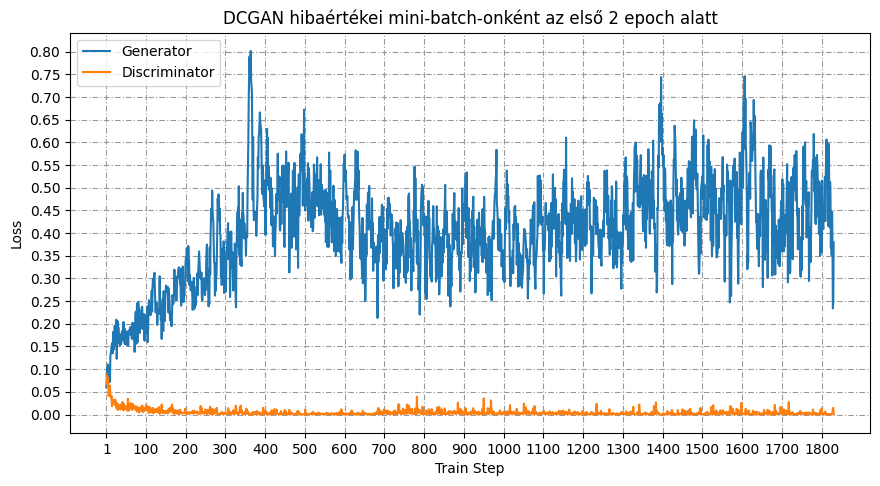

In [14]:
epochs = 2
trainsteps = gen_losses.shape[1] * epochs

gen = gen_losses[:epochs].flatten() / batch_size
disc = disc_losses[:epochs].flatten() / batch_size

fig_1 = plt.figure(figsize=(8, 4), dpi=100)
ax = fig_1.add_axes([0, 0, 1, 1])
ax.set_xlabel('Train Step')
ax.set_ylabel('Loss')
ax.set_title('DCGAN hibaértékei mini-batch-onként az első 2 epoch alatt')
ax.plot(np.linspace(1, trainsteps, trainsteps), gen, label='Generator')
ax.plot(np.linspace(1, trainsteps, trainsteps), disc, label='Discriminator')
ax.legend(loc=0)

ax.grid(True, color='0.6', dashes=(5, 2, 1, 2))
ax.yaxis.set_major_locator(ticker.MultipleLocator(0.05))

x_ticks = np.arange(0, trainsteps+1, 100)
x_ticks[0] = 1
ax.set_xticks(x_ticks)

plt.show()


A modell tanítása nehézkes lehet, ezt kívánom szemléltetni a fenti ábrákkal.
Jól látható, hogy a tanítási folyamat során igen érdekes hibaértékek születnek. Egy tanítási lépés egy minibatch-on történő tanítást jelent, egy epoch pedig az összes minibatch-on való tanítást jelenti.
Ha csak a nyers hibaértékre tekintünk, akkor azt figyelhetjük meg, hogy a tanítási lépések között erősen oszcillálnak az értékek. Kijelenthetjük a látott eredmények alapján, hogy a tanítás valóban nem stabil és egészen random módon változhatnak az értékek.
A szemléltetés kedvéért a következő ábrán a minibatchokon számolt hibaértékek átlagait figyelhetjük meg epoch-onként.

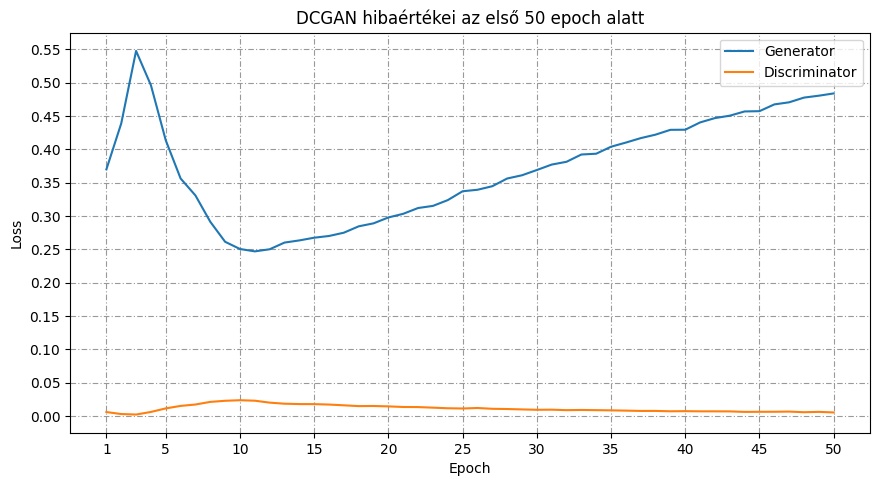

In [15]:
epochs = 50

gen = gen_losses[:epochs].mean(axis=1) / batch_size
disc = disc_losses[:epochs].mean(axis=1) / batch_size

fig_1 = plt.figure(figsize=(8, 4), dpi=100)
ax = fig_1.add_axes([0, 0, 1, 1])
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
ax.set_title('DCGAN hibaértékei az első 50 epoch alatt')
ax.plot(np.linspace(1, epochs, epochs), gen, label='Generator')
ax.plot(np.linspace(1, epochs, epochs), disc, label='Discriminator')
ax.legend(loc=0)

ax.grid(True, color='0.6', dashes=(5, 2, 1, 2))
ax.yaxis.set_major_locator(ticker.MultipleLocator(0.05))

x_ticks = np.arange(0, epochs+1, 5)
x_ticks[0] = 1
ax.set_xticks(x_ticks)
plt.show()

### Az architektúra gyengeségei, problémái

A felvázolt architektúra tanítása során különféle problémák jelentkezhetnek, amelyek a végeredményt kisebb nagyobb mértékben ronthatják.

- A modell ebben a formájában igen hajlamos az mode collapse-re, vagyis a tanulás során jelentkező összeomlásra. A jelenség és az elkerülésére irányuló néhány technika bemutatása a következőkben kerül ismertetésre.

- A konvolúciós rétegek működéséből adódóan csupán lokális pixel-környezetekre képes összefüggő részeket generálni a modell.
	
- A modellnek nincsen információja a különféle osztályokról, csupán a képek rendezetlen halmazán tanul, így magától kell megtanulnia a különféle osztályok jellegzetességeit. Az általánosítás szempontjából ez előnyös is lehet, viszont ha merőben különböző osztályokra szeretnénk betanítani a modellt, akkor az úgynevezett class conditoning technika válhat a segítségünkre.

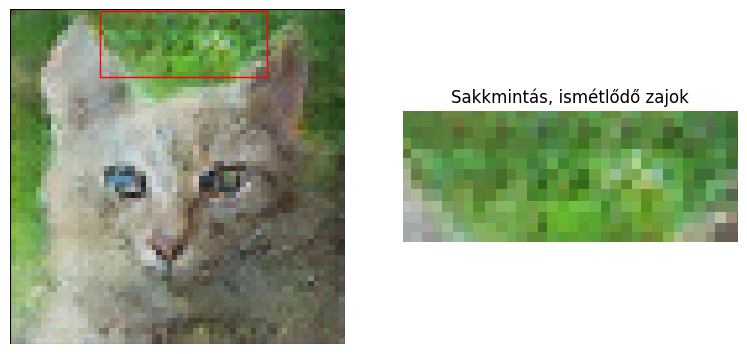

In [16]:
image = mpimg.imread('./images/chessboard.png')

xcoords = (80, 230)
ycoords = (60, 1)

fig, axes = plt.subplots(figsize=(8, 4), nrows=1, ncols=2, dpi=100)
plt.tight_layout()
# Create a Rectangle patch
rect = patches.Rectangle((xcoords[0], ycoords[1]),
                         xcoords[1]-xcoords[0], ycoords[0]-ycoords[1],
                         linewidth=1, edgecolor='r', facecolor='none')

axes[0].add_patch(rect)
axes[0].axis('off')
axes[0].imshow(image, interpolation='none')

axes[1].set_title("Sakkmintás, ismétlődő zajok")
axes[1].set_xlim(xcoords)
axes[1].set_ylim(ycoords)
axes[1].axis('off')

axes[1].imshow(image, interpolation='none')

plt.show()
# AnimalFaces-HQ datasetre betanított modell egy generált képe

## GAN teljesítmény mérés

Az IS és FID mérésére a performace_measure jegyzékben érhetőek el notebook-ok.

A **generate_samples.ipynb** notebook segítségével mintákat generálhatunk NumPy tömbökben kimentve, amelyeket a számolásokhoz felhasználhatunk.

Az IS mérésére a **inception-score.ipynb** notebook szolgál. A kódrészlet a hivatalos implementáció repository-jából lett letöltve: [https://github.com/openai/improved-gan/tree/master/inception_score](https://github.com/openai/improved-gan/tree/master/inception_score)


Az FID mérésének menete:
1. **fidscore-precalc.ipynb** notebook segítségével lehet előállítani a következő lépéshez szükséges statisztikákat. A notebook az adathalmazt vizsgálja meg és a további számolásokhoz szükséges adatokat állítja elő .npz formátumban.

A [https://github.com/bioinf-jku/TTUR](https://github.com/bioinf-jku/TTUR) linken érhető el az FID hivatalos implementációja. A repositoryban több népszerű adathalmazra elvégzett előszámítás is letölthető. A repositoryból került letöltésre a **fid.py** is, amely tartalmazza a számoláshoz szükséges metódusokat.

2. **fidscore.ipynb** notebook segítségével lehet meghatározni az FID értéket a generált minták és az előzőleg kiszámolt értékek alapján.

## Mode collapse jelenség

A Mode collapse jelenség alatt a tanulás során bekövetkező azon anomáliát értjük, amely során a Generátor a látens tér bármely pontjára ugyanolyan kimeneti képet generál. A képek között minimális változatosság ugyan megfigyelhető, viszont a minőségük erősen romlik ilyen esetben. Előfordulhatnak olyan esetek is, amikor egy-egy megtanult képi jellegzetesség jelennek meg a kigenerált képeken teljesen indokolatlanul és ezen jellegek helyére kerülnek újak a további tanítási lépések alatt.

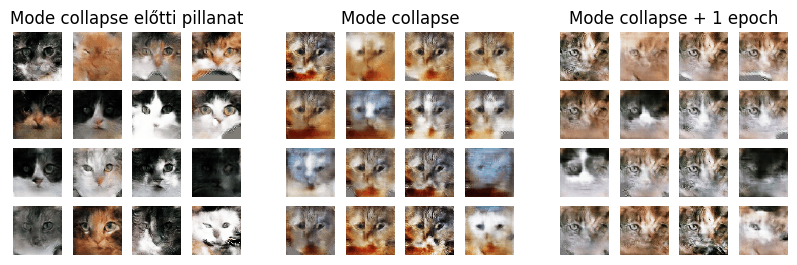

In [17]:
before_collapse = mpimg.imread('./images/before-collapse.png')
collapse01 = mpimg.imread('./images/collapse01.png')
collapse02 = mpimg.imread('./images/collapse02.png')

fig, axes = plt.subplots(figsize=(10, 3), nrows=1, ncols=3, dpi=100)

axes[0].set_title("Mode collapse előtti pillanat")
axes[0].axis('off')
axes[0].imshow(before_collapse, interpolation='none')

axes[1].set_title("Mode collapse")
axes[1].axis('off')
axes[1].imshow(collapse01, interpolation='none')

axes[2].set_title("Mode collapse + 1 epoch")
axes[2].axis('off')
axes[2].imshow(collapse02, interpolation='none')

plt.show()

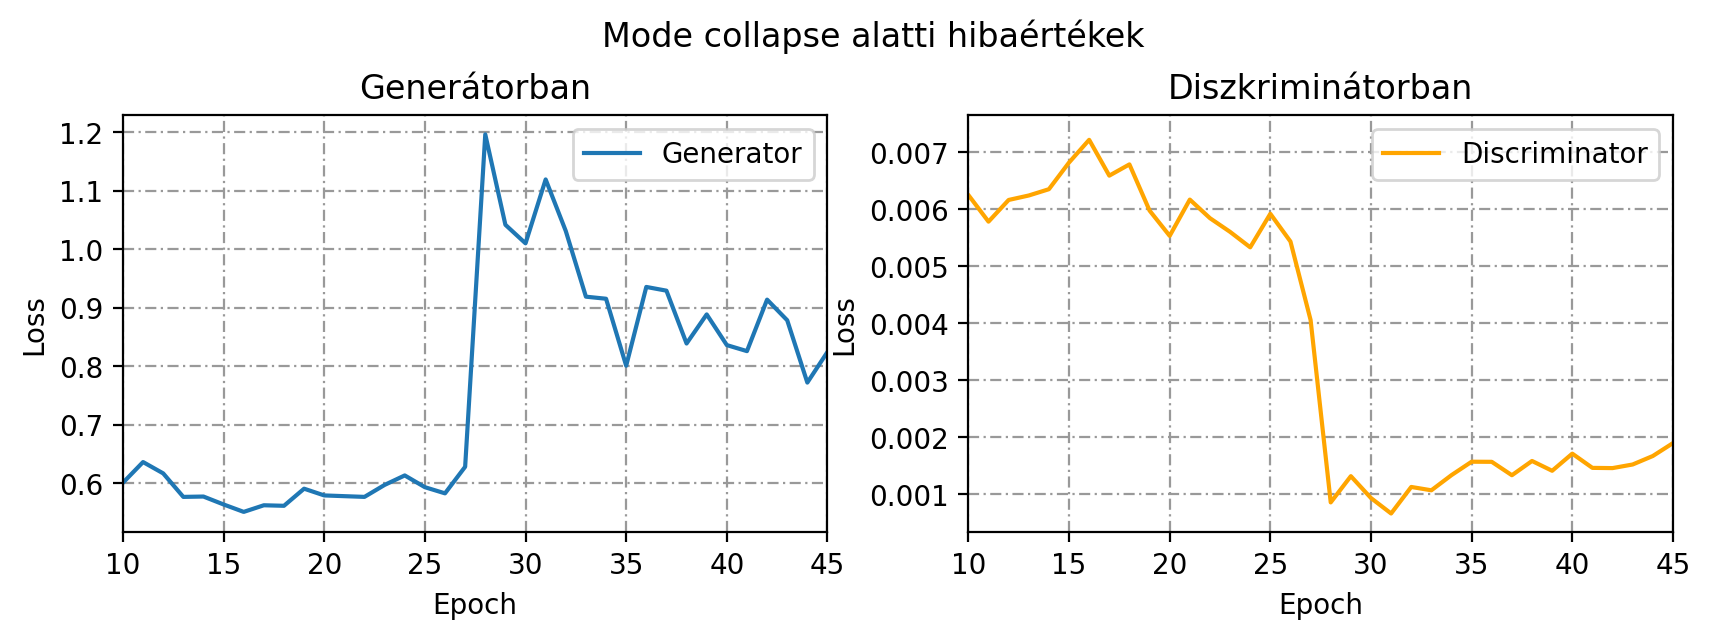

In [18]:
gen_losses = np.load("datas/losses/msggan/modecollapse/modecollapse_generator_losses.npy")
disc_losses = np.load("datas/losses/msggan/modecollapse/modecollapse_discriminator_losses.npy")

batch_size = 16
epochs = 50

gen = gen_losses[:epochs].mean(axis=1) / batch_size
disc = disc_losses[:epochs].mean(axis=1) / batch_size

fig, axes = plt.subplots(figsize=(10, 3), nrows=1, ncols=2, dpi=200)
fig.suptitle('Mode collapse alatti hibaértékek')
fig.subplots_adjust(top=0.82)
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title('Generátorban')
axes[0].plot(np.linspace(1, epochs, epochs), gen, label='Generator')

axes[0].legend(loc=0)

axes[0].grid(True, color='0.6', dashes=(5, 2, 1, 2))
axes[0].yaxis.set_major_locator(ticker.MultipleLocator(0.1))

x_ticks = np.arange(0, epochs+1, 5)
x_ticks[0] = 1
axes[0].set_xticks(x_ticks)
axes[0].set_xlim(xmin=10, xmax=45)

axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].set_title('Diszkriminátorban')
axes[1].plot(np.linspace(1, epochs, epochs), disc, label='Discriminator', color='orange')

axes[1].legend(loc=0)

axes[1].grid(True, color='0.6', dashes=(5, 2, 1, 2))
axes[1].yaxis.set_major_locator(ticker.MultipleLocator(0.001))

x_ticks = np.arange(0, epochs+1, 5)
x_ticks[0] = 1
axes[1].set_xticks(x_ticks)
axes[1].set_xlim(xmin=10, xmax=45)

plt.show()

A fenti ábrán megfigyelhető a generátor és a diszkriminátor hibáinak alakulása a tanulás alatt. A kiugró hibaérték mindkét háló esetében ugyanazon epoch alatt jelentkeztek és a kimeneti képeket megvizsgálva megfigyelhetjük, hogy a modell valóban mode collapse áldozatává vált. Az ábrán azt is megfigyelhetjük, hogy a tanítás egészen korai szakaszában jelentkezett ezen anomália. Ennek oka az, hogy egy olyan adathalmazon tanítottam a modellt, amelyen semmiféle tisztítást nem alkalmaztak.

A mode-collapse detektálása abban az esetben történhet a hibafüggvények vizsgálatával, ha a modellben teljes összeomlás figyelhető meg. A kisebb, lokális mode-collapse-ek esetében nem kapunk ilyen visszajelzést a hibafüggvényektől. A detektálásra alkalmasak lehetnek a validálási/teljesítménymérő módszerek is, vagyis az előbbiekben ismertetett IS és FID módszerek, amelyek a kigenerált képek változatosságát is figyelembe veszik az értékelés során.

## Regularizációs módszerek

A GAN tanítása során nehézségekbe ütközhetünk. Legrosszabb esetben nem is kezd el konvergálni a generátor kimenete a tanítóminta képeihez, viszont abban az esetben gyanakodhatunk, hogy a modellünk nem lett helyesen felépítve. Amennyiben mégis elkezd fejlődni a modell és nem csak zaj jelenik meg a kimeneten az egyes tanítólépések után, de bizonyos számú epoch után mode collapse lép fel, úgy fontolóra vehetjük a következő regularizációs technikákat.

### Label-smoothing

A label-smoothing az egyik legegyszerűbb regularizációs trükk, amely a neurális hálók overfitting problémáját kívánja kiküszöbölni. Ezen módszer alkalmazásához nem szükséges módosítanunk az architektúránkat, csupán a hibafüggvényt, így ez egy egészen egyszerűen implementálható technika. GAN esetében a diszkriminátor hibafüggvényét szokás módosítani oly módon, hogy a bináris keresztentrópia számolás során a valós bemeneti képek 1-es címke helyett valamennyivel alacsonyabb értéket, például 0.9-et kapnak. Ezzel a beállítással a diszkriminátor kevésbé lesz hajlamos a túlzott magabiztosságra a valós bemeneti képek esetén, teret adva a generátor fejlődésének.

In [19]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.constant(np.full(real_output.shape, 0.9)), real_output)
    fake_loss = cross_entropy(tf.constant(np.full(fake_output.shape, 0)), fake_output)
    
    total_loss = real_loss + fake_loss
    return total_loss

### Megfelelő inicializációs stratégia

A mély neurális hálózatoknál igen gyakran előforduló probléma az úgynevezett exploding vagy éppen a vanishing gradiensek jelensége, amelyet gyakran csupán instabil gradienseknek is szokás nevezni.

Az instabil gradiensek megelőzésére az egyik irány a neuronok inicializációs stratégiájának megválasztása.
Az évek során több ajánlás is érkezett, a különböző felépítésű hálózatokra különböző technikák váltak be.
Kiemelnék két inicializációs technikát, a Glorot és a He stratégiákat, amelyek széleskörűen alkalmazhatónak bizonyultak.

A kezdőértékek generálásához figyelembe veszik a rétegek be- és kimeneti kapcsolatainak számát is, amelyet $fan_{in}$ és $fan_{out}$-nak is nevezhetünk és azok átlagát használják fel a számoláshoz.

$$fan_{avg} = \frac{fan_{in} + fan_{out}}{2}$$

A __Glorot/Xavier__ inicializációs stratégia normális és egyenletes eloszlásra is számolható.
Normális eloszlás esetén a várható értéket $m = 0$-ra kell választani, a szórásnégyzet pedig: $ \sigma^2 = \frac{1}{fan_{avg}} $.

$$ \mathcal{N}(0, \frac{1}{fan_{avg}}) $$

Egyenletes eloszlás esetén $\pm r$ között,

$$r = \sqrt{\frac{3}{fan_{avg}}}$$

$$ \mathcal{U}\left[-r, r\right] $$

Ezen inicializációs stratégia a tangens-hiperbolikusz, logisztikus és softmax aktivációs függvényekkel rendelkező rétegekben használatosak. 

A __He/Kaiming__ inicializáció hasonló megközelítést alkalmaz,
Normális eloszlásra:

$$ \mathcal{N}(0, \frac{2}{fan_{in}}) $$

Egyenletes eloszlásra:

$$r = \sqrt{3\frac{2}{fan_{in}}}$$

$$ \mathcal{U}\left[-r, r\right] $$

Ezen inicializációs stratégia pedig a ReLU aktivációs függvények családjával rendelkező rétegekben ajánlott használni.

A Keras a Glorot inicializálást használja alapértelmezetten.

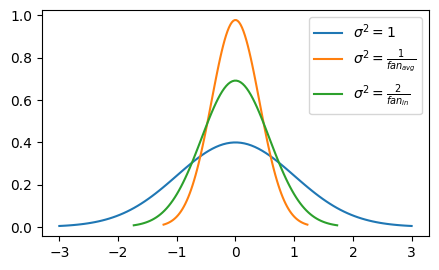

In [20]:
import math
import scipy.stats as stats

def plot_normal(mu, variance, label):
    sigma = math.sqrt(variance)
    x = np.linspace(mu - 3*sigma, mu + 3*sigma, 100)
    plt.plot(x, stats.norm.pdf(x, mu, sigma), label=label)
    

fan_in = 6
fan_out = 6

plt.figure(figsize=(5,3), dpi=100)
plot_normal(0, 1, r'$\sigma^2 = 1$')
plot_normal(0, 1/((fan_in + fan_out)/2), r'$\sigma^2 = \frac{1}{fan_{avg}}$')
plot_normal(0, 2/fan_in, r'$\sigma^2 = \frac{2}{fan_{in}}$')
plt.legend(loc=0)
plt.show()

Az alábbi kódrészletben egy "dummy" háló kerül felépítésre, különböző inicializációs stratégiákkal. Majd a bemenetén egy 1.0 értéket beadva megfigyeljük, hogy mi jelenik meg a kimeneten. A relu aktivációs függvények alkalmazása mellett a glorot és a normális eloszlással inicializált súlyok hatására a tanulatlan hálón is megfigyelhetőek a 0-hoz tartó értékek.

In [21]:
def calc_forwardprop(input_value, hidden_layers, activation, initializer):
    visible = keras.layers.Input(shape=[1])
    hidden = visible
    for i in range(hidden_layers):
        hidden = keras.layers.Dense(512, activation=activation, kernel_initializer=initializer)(hidden)
    model = keras.models.Model(inputs=visible, outputs=[hidden])

    output = model(input_value, training=False)
    mean = "{:.20f}".format(output.numpy().mean())
    std = "{:.20f}".format(output.numpy().std())
    print(f"A model with {hidden_layers} hidden layers, {activation} activation, {initializer} initializer")
    print(f"Mean: {mean}")
    print(f"Std: {std}\n")

hidden_layers = 20
input_value = tf.constant([1.0])
calc_forwardprop(input_value, hidden_layers, "relu", "glorot_normal")
calc_forwardprop(input_value, hidden_layers, "relu", "random_normal")
calc_forwardprop(input_value, hidden_layers, "relu", "he_normal")

A model with 20 hidden layers, relu activation, glorot_normal initializer
Mean: 0.00002823910290317144
Std: 0.00004311590237193741

A model with 20 hidden layers, relu activation, random_normal initializer
Mean: 0.00030066340696066618
Std: 0.00044866619282402098

A model with 20 hidden layers, relu activation, he_normal initializer
Mean: 0.76615786552429199219
Std: 1.01579189300537109375



### Batch Normalization

A Batch Normalization technika zero-centerezi és normalizálja az inputokat, majd skálázza és shifteli az eredményeket. Vagyis két tanulható paramétervektor jelenik meg rétegenként a modellünkben, a skálázásra és shiftelés műveletre. A technika neve a mini-batch tanítási stratégiából adódik, vagyis amikor egy tanítási lépést nem a teljes dataset-re hajtunk végre, csupán egy annak kisebb szeletére. A Batch Normalization zero-centerező és normalizáló lépéséhez az algoritmusnak meg kell becsülnie az aktuális bemeneti mini-batch várható értékét és szórását. Ezt a becslést csupán tanítási időben tudja megtenni az algoritmus, hiszen olyankor rendelkezésére áll a teljes mini-batch. Viszont tesztelésnél, amikor csupán egy-egy tesztadatot lát a modell, úgy nem hagyatkozhatunk a becsült várhatóértékre és szórásra. A Keras-ban található implementáció a tanulás során mozgóátlaggal vezeti a várhatóértékeket és a szórásokat. Ez további két paramétert jelent, amelyeket a modell a tanulási folyamat során fog meghatározni a már említett módon.

In [22]:
visible = keras.layers.Input(shape=[1])
hidden = keras.layers.BatchNormalization()(visible)
model = keras.models.Model(inputs=visible, outputs=[hidden])

model.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 1)]               0         
_________________________________________________________________
batch_normalization (BatchNo (None, 1)                 4         
Total params: 4
Trainable params: 2
Non-trainable params: 2
_________________________________________________________________


A fenti kis példa egy olyan hálózatot definiál, amelyben egyetlen Batch Normalization réteg található. Mint látható valóban 4 paraméterrel rendelkezik a réteg, viszont azokból csak kettő tanítható, amelyek a $\gamma$ skálázó és $\beta$ shiftelő paraméterek. A másik két paraméter a már említett mozgó-átlag és szórás, amelyeket a Keras a tanítás során számol ki.

### Two Time-Scale Update Rule (TTUR)
Ezen technikát szintén meg lehet valósítani architektúrális változtatás nélkül, csupán az Adam optimalizáló eljárás egyik paraméterét kell megfelelően beállítani az implementációjához.
Heusel et al. cikkjében mérésekkel alátámasztották, hogy ha az Adam optimalizáló módszert választjuk a GAN tanításához és a learning rate paramétert a generátorban és a diszkriminátorban különbözőre állítjuk, úgy a modell gyorsabban és stabilabban fog konvergálni a lokális optimumokhoz.
Például a Generátor optimalizálójában a 0.0001-es tanulási mérték és a Diszkriminátor optimalizálójában meállított 0.0004 érték ezt a technikát valósítja meg.


In [23]:
generator_optimizer = keras.optimizers.Adam(1e-4)
discriminator_optimizer = keras.optimizers.Adam(4e-4)

## A képgeneráló modell kibővítési lehetőségei

A felvázolt GAN architektúra kiinduló alapként szolgálhat különféle háló típusokhoz. Az irodalomkutatás során talált megoldásokban is megfigyelhető, hogy a mély-konvolúciós szerkezeten alapuló megoldásokat alkalmaznak különféle kiegészítésekkel. A jobb eredmény érdekében igen szerteágazó kiegészítési javaslatok jelentek meg, ezen alfejezetben két kibővítési lehetőség kerül ismertetésere.

### Tanítás címkékkel

In [24]:
latent_dim = 100
number_of_classes = 10

def make_generator_base_model(latent_dim):
    noise = keras.layers.Input(shape=[latent_dim])

    hidden = keras.layers.Reshape((1, 1, latent_dim), name="reshape")(noise)

    hidden = keras.layers.Conv2DTranspose(512, 4, 1, 'valid')(hidden)
    hidden = keras.layers.BatchNormalization(momentum=0.9)(hidden)
    hidden = keras.layers.ReLU()(hidden)

    hidden = keras.layers.Conv2DTranspose(256, 3, 2, 'same')(hidden)
    hidden = keras.layers.BatchNormalization(momentum=0.9)(hidden)
    hidden = keras.layers.ReLU()(hidden)

    hidden = keras.layers.Conv2DTranspose(128, 3, 2, 'same')(hidden)
    hidden = keras.layers.BatchNormalization(momentum=0.9)(hidden)
    hidden = keras.layers.ReLU()(hidden)

    hidden = keras.layers.Conv2DTranspose(3, 3, 2, 'same')(hidden)
    out = keras.layers.Activation("tanh")(hidden)

    return keras.models.Model(noise, out, name="generator")

In [25]:
def make_label_conditioning_generator(latent_dim, number_of_classes, base_generator):
    noise = keras.layers.Input(shape=[latent_dim], name="noise")
    label = keras.layers.Input(shape=(1, ), name="label")
    label_embedding = keras.layers.Embedding(number_of_classes, latent_dim, name="embedding")(label)
    label_embedding = keras.layers.Flatten(name="flatten")(label_embedding)    
    gen_input = keras.layers.Multiply(name="multiply")([noise, label_embedding])

    base_out = base_generator(gen_input)

    return keras.models.Model([noise, label], base_out)

In [26]:
generator_base = make_generator_base_model(latent_dim)
label_conditioning_generator = make_label_conditioning_generator(latent_dim, number_of_classes, generator_base)

In [27]:
label_conditioning_generator.summary()

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
label (InputLayer)              [(None, 1)]          0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 1, 100)       1000        label[0][0]                      
__________________________________________________________________________________________________
noise (InputLayer)              [(None, 100)]        0                                            
__________________________________________________________________________________________________
flatten (Flatten)               (None, 100)          0           embedding[0][0]                  
____________________________________________________________________________________________

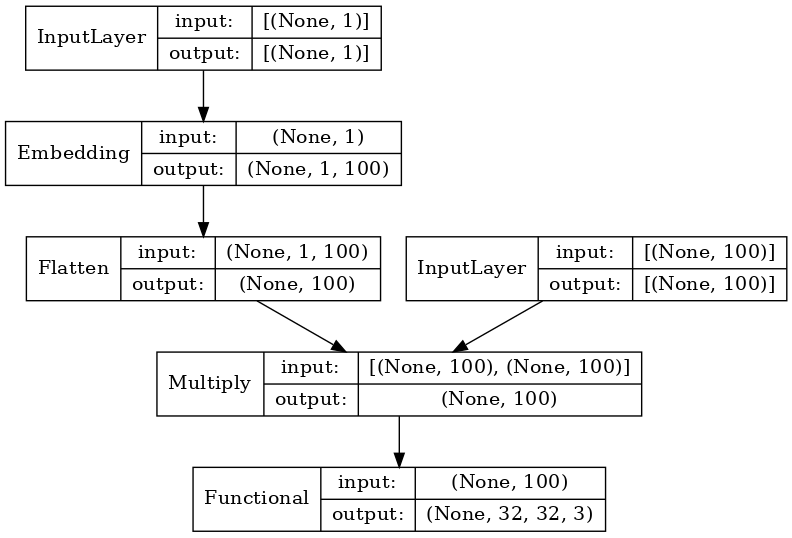

In [28]:
keras.utils.plot_model(label_conditioning_generator, dpi=100, show_shapes=True, show_layer_names=False)

In [29]:
def make_feature_extractor_model(latent_dim):
    image = keras.layers.Input(shape=(32, 32, 3))

    hidden = keras.layers.Conv2D(128, 3, 2, 'same')(image)
    hidden = keras.layers.BatchNormalization(momentum=0.9)(hidden)
    hidden = keras.layers.ReLU()(hidden)

    hidden = keras.layers.Conv2D(256, 3, 2, 'same')(hidden)
    hidden = keras.layers.BatchNormalization(momentum=0.9)(hidden)
    hidden = keras.layers.ReLU()(hidden)

    hidden = keras.layers.Conv2D(512, 3, 2, 'same')(hidden)
    hidden = keras.layers.BatchNormalization(momentum=0.9)(hidden)
    hidden = keras.layers.ReLU()(hidden)

    hidden = keras.layers.Conv2D(latent_dim, 4, 1, 'valid', name="convka")(hidden)
    hidden = keras.layers.ReLU()(hidden)
    features = keras.layers.Flatten()(hidden)

    return keras.models.Model(image, features, name="featureExt")

In [30]:
def make_label_conditioning_discriminator(latent_dim, number_of_classes, feture_extractor):
    image = keras.layers.Input(shape=(32, 32, 3), name="image")

    label = keras.layers.Input(shape=(1, ), name="label")

    features = feature_extractor(image)

    label_embedding = keras.layers.Embedding(number_of_classes, latent_dim, name="embedding")(label)
    label_embedding = keras.layers.Flatten(name="flatten")(label_embedding)
    embedded_space = keras.layers.Multiply(name="multiply")([features, label_embedding]) 

    hidden = keras.layers.Dropout(0.3, name="dropout")(embedded_space)
    out = keras.layers.Dense(1, name="output")(hidden)

    return keras.models.Model([image, label], out)

In [31]:
feature_extractor = make_feature_extractor_model(latent_dim)
label_conditioning_discriminator = make_label_conditioning_discriminator(latent_dim, number_of_classes, feature_extractor)

In [32]:
label_conditioning_discriminator.summary()

Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
label (InputLayer)              [(None, 1)]          0                                            
__________________________________________________________________________________________________
image (InputLayer)              [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 1, 100)       1000        label[0][0]                      
__________________________________________________________________________________________________
featureExt (Functional)         (None, 100)          2301796     image[0][0]                      
____________________________________________________________________________________________

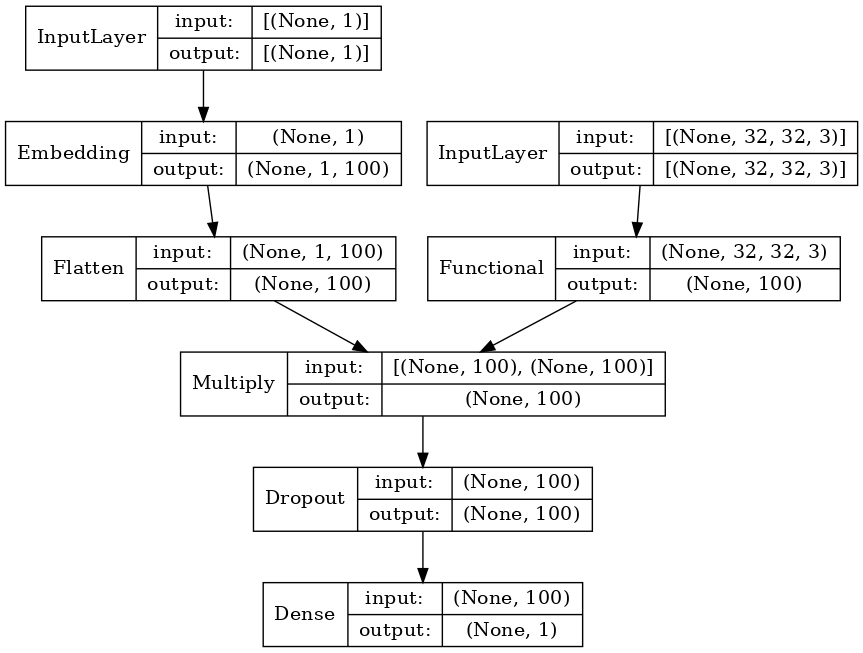

In [33]:
keras.utils.plot_model(label_conditioning_discriminator, dpi=100, show_shapes=True, show_layer_names=False)

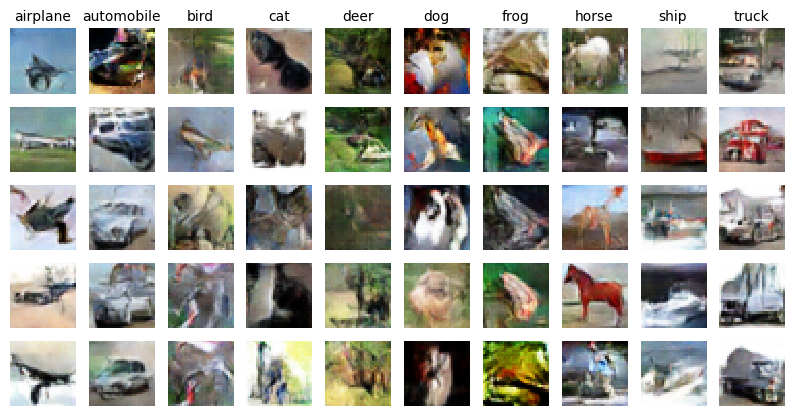

In [34]:
label_conditioning_generator =\
    keras.models.load_model('./datas/weights/label_conditioning/generatorcifar10.h5')

class_names = ["airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]
# Ezen modell 512 dimenziójú látens térrel rendelkezik,
# A mode-collapse-re így kevésbé volt érzékeny
noises = tf.random.normal([5, 512])

fig, axes = plt.subplots(figsize=(10, 5), nrows=5, ncols=10, dpi=100)
for i in range(len(class_names)):
    example_images = label_conditioning_generator((noises, tf.constant(np.full(5, i))), training=False)
    for j in range(len(example_images)):
        if(j == 0):
            axes[j, i].set_title(class_names[i], fontdict={'fontsize': 10})
        axes[j, i].imshow((example_images[j].numpy() * 127.5 + 127.5).astype("uint32"), interpolation="none")
        axes[j, i].axis('off')
plt.show()

### Multi-Scale Gradient architektúra

Egy másik kiegészítésként a Multi-Scale Gradient(MSG) alapján több ki- és bemenettel láttam el a generátort és a diszkriminátort. Igyekeztem az eredeti modellemet kiegészíteni és alkalmazni az MSG-ben látottakat, vagyis az U-net szerű kapcsolatokat.

A következő példa egy olyan architektúrát mutat be amely 4 kimenettel rendelkezik és rendre: $4 \times 4$, $8 \times 8$, $16 \times 16$ és $32 \times 32$ felbontású képeket generál egyszerre.

In [35]:
def make_generator_model(latent_dim):
    visible = keras.layers.Input(shape=[latent_dim])
    hidden = keras.layers.Reshape((1, 1, 100))(visible)

    hidden = keras.layers.Conv2DTranspose(filters=512, kernel_size=4, strides=(1, 1),
                                          padding='valid', activation="relu")(hidden)
    hidden = keras.layers.BatchNormalization()(hidden)
    out4x4 = hidden
    out4x4 = keras.layers.Conv2D(filters=3, kernel_size=4, strides=(1, 1), padding='same')(out4x4)
    out4x4 = keras.layers.Activation("tanh")(out4x4)


    hidden = keras.layers.Conv2DTranspose(filters=256, kernel_size=4, strides=(2, 2),
                                          padding='same', activation="relu", kernel_initializer="he_normal")(hidden)
    hidden = keras.layers.BatchNormalization()(hidden)
    out8x8 = hidden
    out8x8 = keras.layers.Conv2D(filters=3, kernel_size=4, strides=(1, 1), padding='same')(out8x8)
    out8x8 = keras.layers.Activation("tanh")(out8x8)


    hidden = keras.layers.Conv2DTranspose(filters=128, kernel_size=4, strides=(2, 2),
                                          padding='same', activation="relu", kernel_initializer="he_normal")(hidden)
    hidden = keras.layers.BatchNormalization()(hidden)
    out16x16 = hidden
    out16x16 = keras.layers.Conv2D(filters=3, kernel_size=4, strides=(1, 1), padding='same')(out16x16)
    out16x16 = keras.layers.Activation("tanh")(out16x16)

    hidden = keras.layers.Conv2DTranspose(filters=64, kernel_size=4, strides=(2, 2),
                                          padding='same', activation="relu", kernel_initializer="he_normal")(hidden)
    hidden = keras.layers.BatchNormalization()(hidden)
    hidden = keras.layers.Conv2D(filters=3, kernel_size=4, strides=(1, 1), padding='same')(hidden)
    out32x32 = keras.layers.Activation("tanh")(hidden)
    model = keras.models.Model(inputs=visible, outputs=[out32x32, out16x16, out8x8, out4x4])

    return model

In [36]:
msg_generator = make_generator_model(latent_dim)
msg_generator.summary()

Model: "model_6"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            [(None, 100)]        0                                            
__________________________________________________________________________________________________
reshape_1 (Reshape)             (None, 1, 1, 100)    0           input_7[0][0]                    
__________________________________________________________________________________________________
conv2d_transpose_9 (Conv2DTrans (None, 4, 4, 512)    819712      reshape_1[0][0]                  
__________________________________________________________________________________________________
batch_normalization_7 (BatchNor (None, 4, 4, 512)    2048        conv2d_transpose_9[0][0]         
____________________________________________________________________________________________

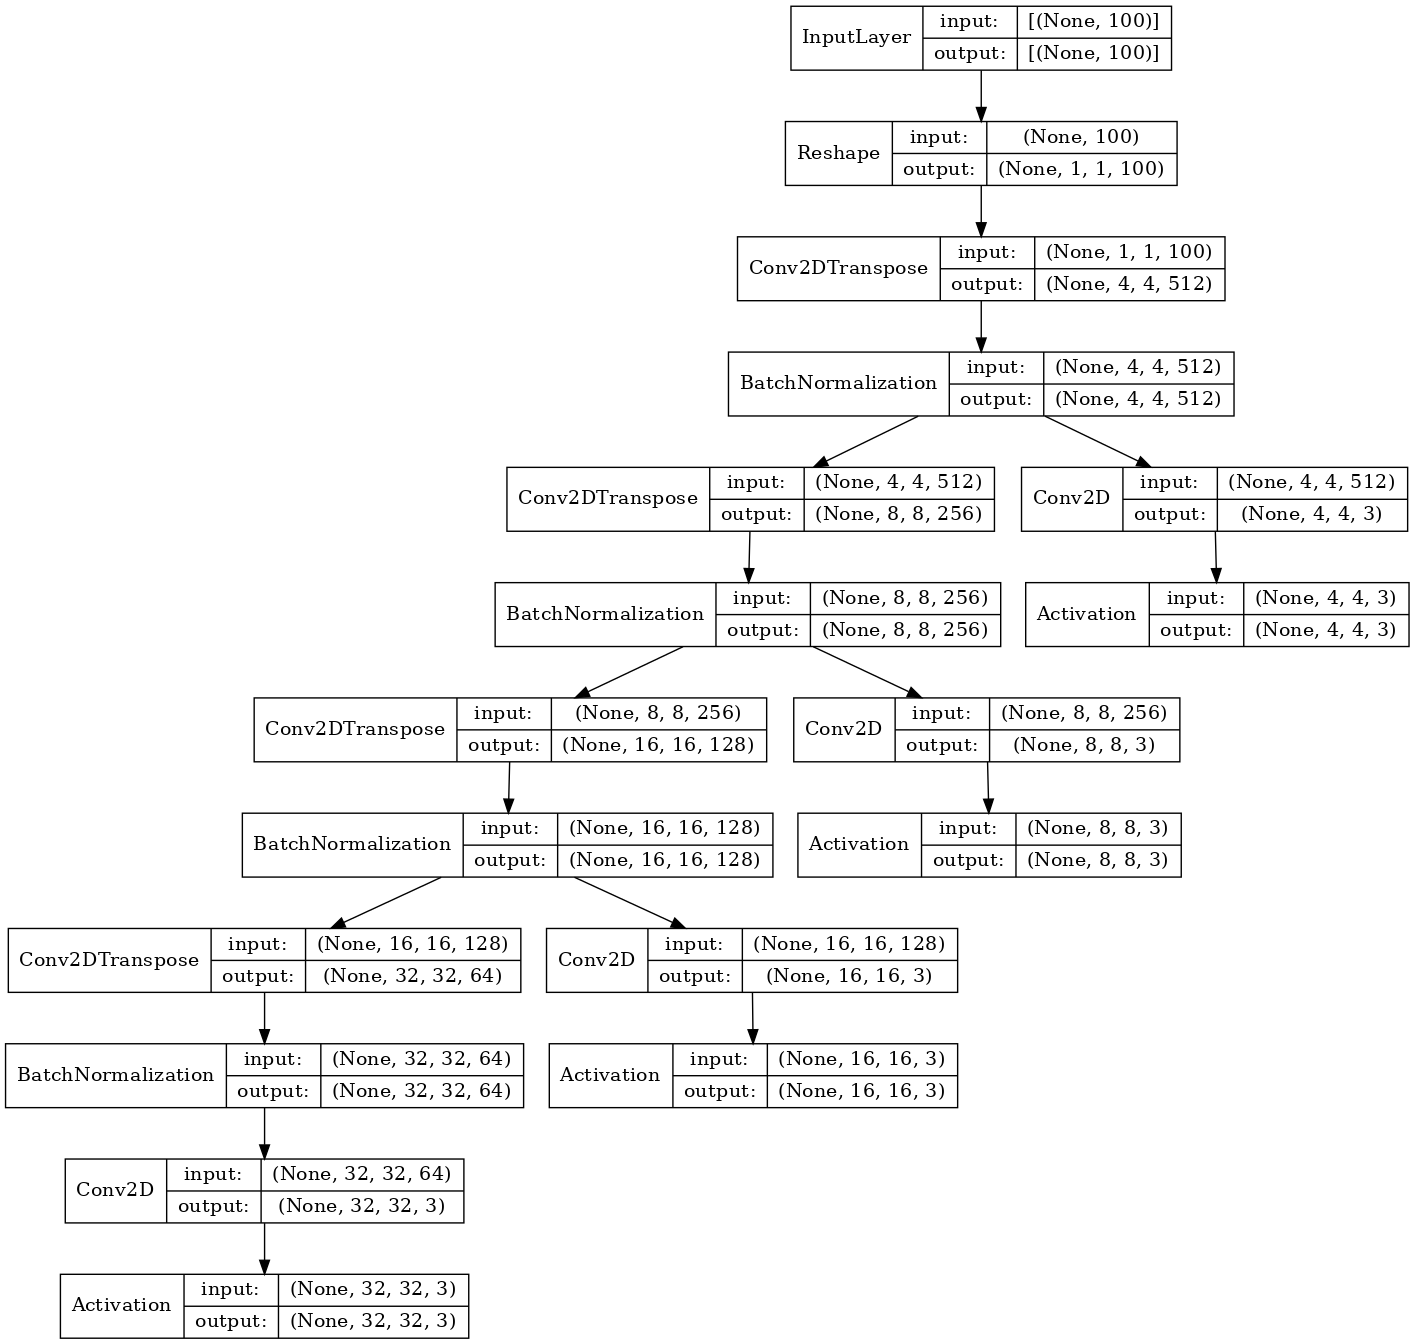

In [37]:
keras.utils.plot_model(msg_generator, dpi=100, show_shapes=True, show_layer_names=False)

In [38]:
def plot_examples_msg(images_at_scales):
    n_examples = images_at_scales[0].shape[0]
    fig, axes = plt.subplots(figsize=(4, n_examples), nrows=n_examples, ncols=4, dpi=150)
    for i in range(n_examples):
        for j in range(4):
            generated_images = images_at_scales[3-j]
            gen_1 = generated_images[i].numpy()*127.5+127.5
            axes[i, j].axis('off')
            axes[i, j].imshow((gen_1).astype("uint32"), interpolation='none')
    plt.show()

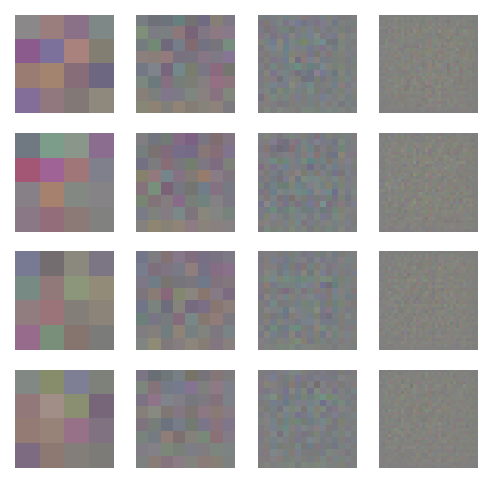

In [39]:
# Példák a generátor kimeneteire a tanítás előtt

noise = tf.random.normal([4, latent_dim])
generated_image = msg_generator(noise, training=False)

plot_examples_msg(generated_image)

In [40]:
def make_discriminator_model():
    input1 = keras.layers.Input(shape=(32, 32, 3))
    hidden = keras.layers.Conv2D(filters=128, kernel_size=4, strides=2, padding="same",
                                 activation="relu", kernel_initializer="he_normal")(input1)
    hidden = keras.layers.BatchNormalization()(hidden)

    input2 = keras.layers.Input(shape=(16, 16, 3))
    inputfeature2 = keras.layers.Conv2D(128, 3, 1, padding="same")(input2)
    hidden = keras.layers.Concatenate()([hidden, inputfeature2])
    hidden = keras.layers.Conv2D(filters=256, kernel_size=4, strides=2, padding="same",
                                 activation="relu", kernel_initializer="he_normal")(hidden)
    hidden = keras.layers.BatchNormalization()(hidden)

    input3 = keras.layers.Input(shape=(8, 8, 3))
    inputfeature3 = keras.layers.Conv2D(256, 3, 1, padding="same")(input3)
    hidden = keras.layers.Concatenate()([hidden, inputfeature3])
    hidden = keras.layers.Conv2D(filters=512, kernel_size=4, strides=2, padding="same",
                                 activation="relu", kernel_initializer="he_normal")(hidden)
    hidden = keras.layers.BatchNormalization()(hidden)

    input4 = keras.layers.Input(shape=(4, 4, 3))
    inputfeature4 = keras.layers.Conv2D(512, 3, 1, padding="same")(input4)
    hidden = keras.layers.Concatenate()([hidden, inputfeature4])

    hidden = keras.layers.Conv2D(filters=100, kernel_size=4, strides=1, padding="valid", activation="relu")(hidden)

    out = keras.layers.Dense(1)(hidden)

    model = keras.models.Model(inputs=[input1, input2, input3, input4], outputs=[out])
    return model

In [41]:
msg_discriminator = make_discriminator_model()
decision = msg_discriminator(generated_image, training=False)
print(decision)

tf.Tensor(
[[[[ 0.00579846]]]


 [[[-0.00385208]]]


 [[[-0.02511735]]]


 [[[-0.00338102]]]], shape=(4, 1, 1, 1), dtype=float32)


In [42]:
msg_discriminator.summary()

Model: "model_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_8 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_12 (Conv2D)              (None, 16, 16, 128)  6272        input_8[0][0]                    
__________________________________________________________________________________________________
input_9 (InputLayer)            [(None, 16, 16, 3)]  0                                            
__________________________________________________________________________________________________
batch_normalization_11 (BatchNo (None, 16, 16, 128)  512         conv2d_12[0][0]                  
____________________________________________________________________________________________

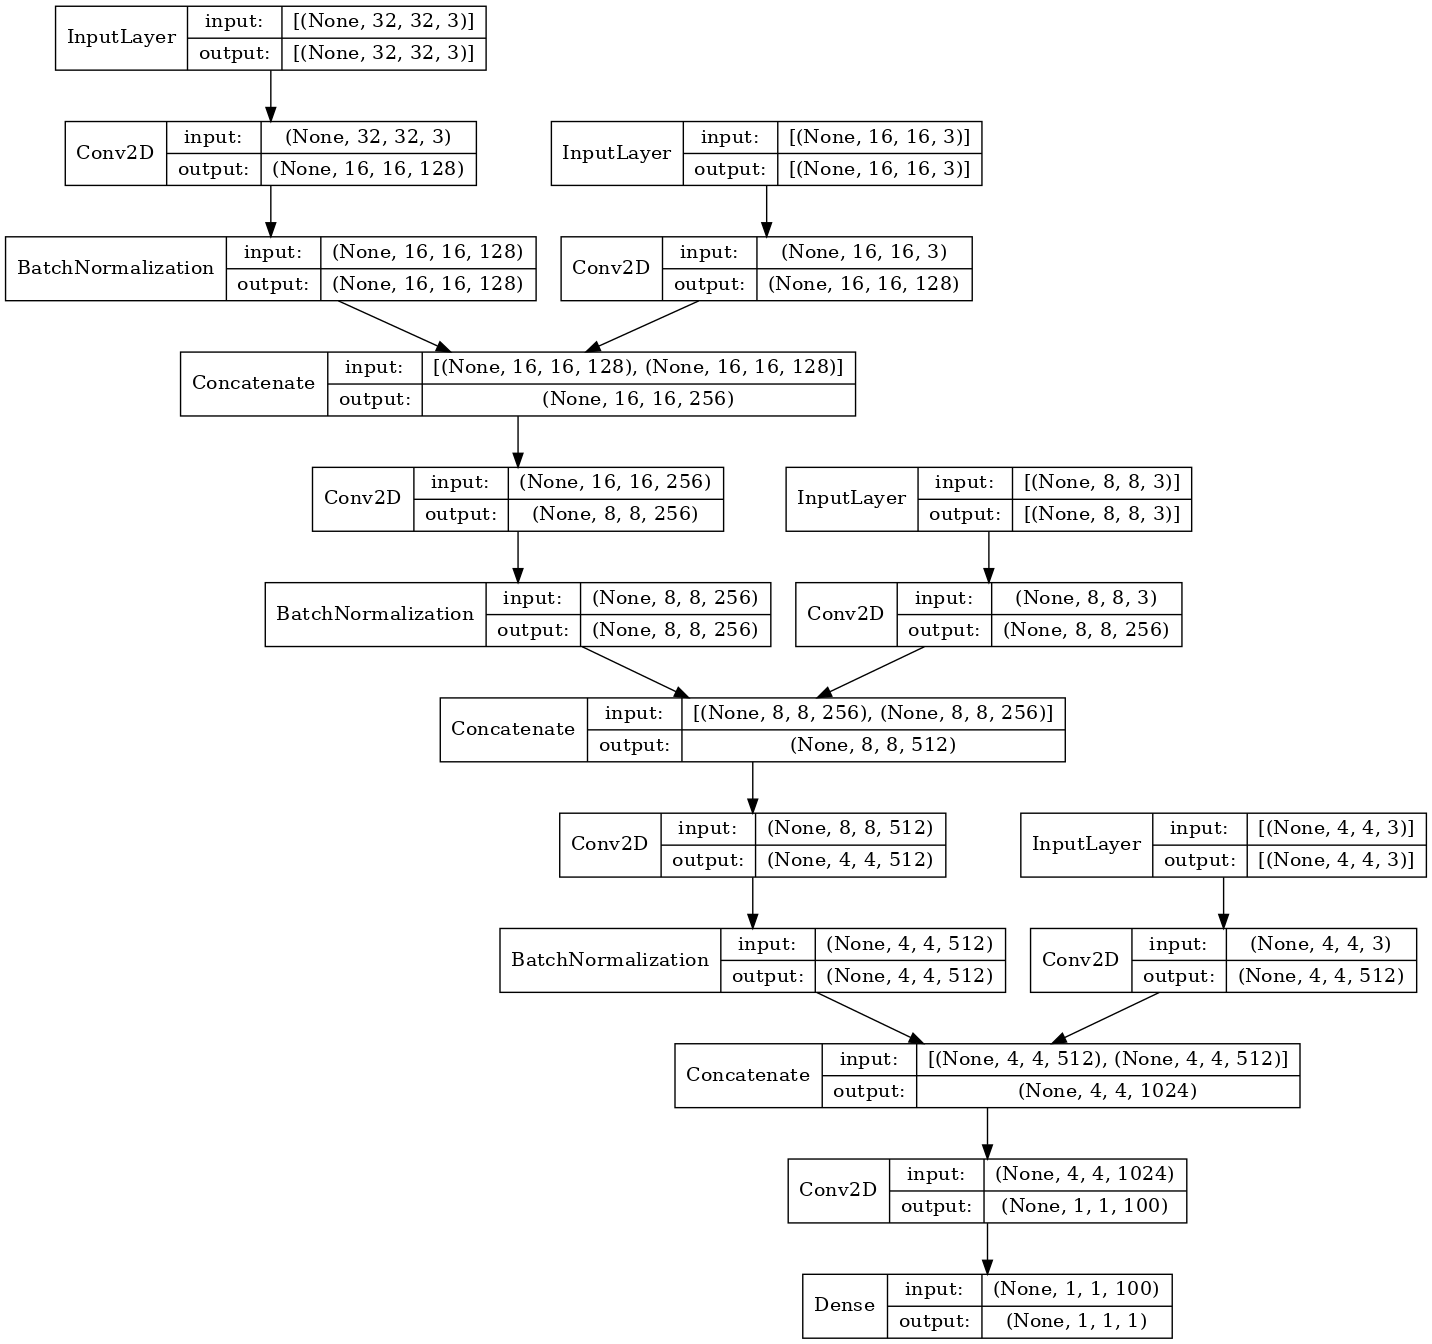

In [43]:
keras.utils.plot_model(msg_discriminator, dpi=100, show_shapes=True, show_layer_names=False)

In [44]:
# Egy betanított modell betöltése, majd példák generálása

msg_generator =\
    keras.models.load_model('./datas/weights/msggan/cifar10/msgGeneratorCifar10.h5')

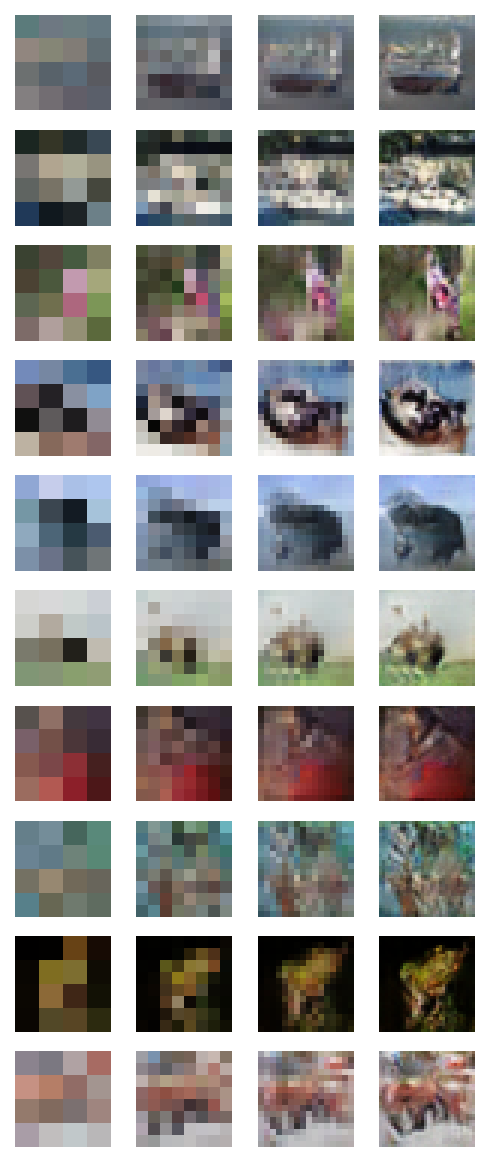

In [45]:
noise = tf.random.normal([10, latent_dim])
generated_image = msg_generator(noise, training=False)

plot_examples_msg(generated_image)